# ML Business Case
## Imad Al moslli - Adnan Asadullah - Ahmed amine Majdoubi 

In [0]:
import numpy as np
import pandas as pd
import datetime
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from pre_processing import pre_processing, split
from regressor import Regressor
import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer, r2_score
from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# Reading Data

In [0]:
store = pd.read_csv("store.csv", engine="python") 
train = pd.read_csv('train.csv', engine="python")
test = pd.read_csv('test.csv', engine="python")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


Le jeu de test représente 4% des données par rapport au jeu de données d'entrainement

In [6]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


# Feature Engineering

In [0]:
# merge datasets
df = train.merge(store, how="left", on='Store')

In [8]:
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
df.isna().sum() / df.shape[0]

Store                        0.000000
DayOfWeek                    0.000000
Date                         0.000000
Sales                        0.000000
Customers                    0.000000
Open                         0.000000
Promo                        0.000000
StateHoliday                 0.000000
SchoolHoliday                0.000000
StoreType                    0.000000
Assortment                   0.000000
CompetitionDistance          0.002597
CompetitionOpenSinceMonth    0.317878
CompetitionOpenSinceYear     0.317878
Promo2                       0.000000
Promo2SinceWeek              0.499436
Promo2SinceYear              0.499436
PromoInterval                0.499436
dtype: float64

In [10]:
(df[df['Promo2']==1][['Promo2SinceWeek', 'Promo2SinceYear']].isna().sum() / df[
    df['Promo2']==1][['Promo2SinceWeek', 'Promo2SinceYear']].shape[0])

Promo2SinceWeek    0.0
Promo2SinceYear    0.0
dtype: float64

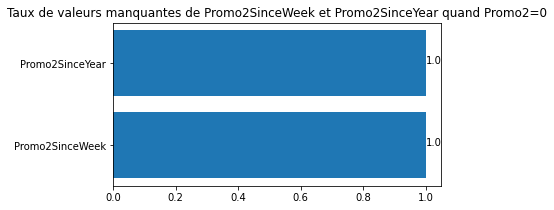

In [11]:
plt.figure(figsize=(20, 3))

names = ['Promo2SinceWeek', 'Promo2SinceYear']

values = [
    (df[df['Promo2']==0][['Promo2SinceWeek', 'Promo2SinceYear']].isna().sum() / df[
    df['Promo2']==0][['Promo2SinceWeek', 'Promo2SinceYear']].shape[0])[0],
    
    (df[df['Promo2']==0][['Promo2SinceWeek', 'Promo2SinceYear']].isna().sum() / df[
    df['Promo2']==0][['Promo2SinceWeek', 'Promo2SinceYear']].shape[0])[1]
]

plt.subplot(131)
plt.barh(names, values)

for index, value in enumerate(values):
    plt.text(value, index, str(value))
    
plt.title('Taux de valeurs manquantes de Promo2SinceWeek et Promo2SinceYear quand Promo2=0')
plt.show()

In [0]:
df = pre_processing(df, test=0)

In [13]:
df.columns

Index(['Store', 'AvgSales', 'AvgCustomers', 'DayOfWeek', 'Date', 'Sales',
       'Customers', 'Open', 'Promo', 'SchoolHoliday', 'CompetitionDistance',
       'Promo2', 'DayOfMonth', 'Month', 'Year', 'MonthsSinceCompetition',
       'WeeksSincePromo2', 'StateHoliday_0', 'StateHoliday_a',
       'StateHoliday_b', 'StateHoliday_c', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b',
       'Assortment_c'],
      dtype='object')

# Feature selection

In [0]:
X_train, X_test, y_train, y_test = split(df)

y_train_sales = y_train["Sales"]
y_test_sales = y_test["Sales"]
y_train_customers = y_train["Customers"]
y_test_customers = y_test["Customers"]

In [15]:
X_train.columns

Index(['Store', 'AvgSales', 'AvgCustomers', 'DayOfWeek', 'Open', 'Promo',
       'SchoolHoliday', 'CompetitionDistance', 'Promo2', 'DayOfMonth', 'Month',
       'Year', 'MonthsSinceCompetition', 'WeeksSincePromo2', 'StateHoliday_0',
       'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a',
       'Assortment_b', 'Assortment_c'],
      dtype='object')

In [0]:
n_features = 30

### Modèle customers

In [0]:
model_customers=Regressor()
model_customers.fit(X_train, y_train_customers)

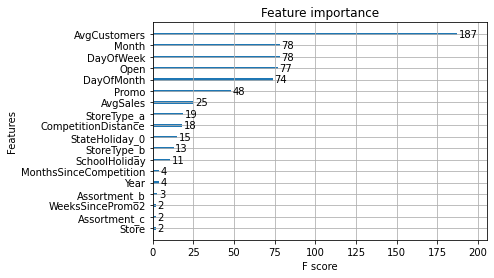

In [18]:
model_customers.plot_importance()
plt.show()

In [0]:
def model_expl(model_customers):
    names = []
    values = []

    # Fit model using each importance as a threshold
    #thresholds = np.sort(model_customers.feature_importances_)
    x = model_customers.get_booster()
    sorted_x = {k: v for k, v in sorted(x.items(), key=lambda item: item[1])}
    sorted_features = [] 
    for key in sorted_x.keys(): 
        sorted_features.append(key)

    for i in range(len(sorted_features) - 1):
        # select features using threshold
        #selection = SelectFromModel(model_customers, threshold=thresh, prefit=True)
        #select_X_train = selection.transform(X_train)
        select_X_train = X_train[sorted_features[i:-1]]
        # train model
        selection_model = xgb.XGBRegressor(silent=True)
        selection_model.fit(select_X_train, y_train_customers)
        # eval model
        select_X_test = X_test[sorted_features[i:-1]]
        predictions = selection_model.predict(select_X_test)
        r2 = r2_score(y_test_customers, predictions)
        print("n=%d, R2: %.2f" % (select_X_train.shape[1], r2))
        names.append(select_X_train.shape[1]) #n
        values.append(r2) #R2
    return names, values, sorted_features

In [0]:
x = model_customers.get_booster()

In [21]:
predictions = model_customers.predict(X_test)
r2 = r2_score(y_test_customers, predictions)
print("R2: %.2f" % (r2))

R2: 0.94


In [22]:
names, values, sorted_features = model_expl(model_customers)

n=17, R2: 0.89
n=16, R2: 0.89
n=15, R2: 0.89
n=14, R2: 0.89
n=13, R2: 0.88
n=12, R2: 0.88
n=11, R2: 0.88
n=10, R2: 0.88
n=9, R2: 0.85
n=8, R2: 0.85
n=7, R2: 0.83
n=6, R2: 0.82
n=5, R2: 0.37
n=4, R2: 0.36
n=3, R2: 0.35
n=2, R2: 0.31
n=1, R2: -0.00


In [0]:
def plot_bar(names, values, title="Performance du modèle customers en fonction du nombre de variables conservées"):
    plt.figure(figsize=(25, 5))
    plt.subplot(131)
    graph = sns.barplot(names, values)

    #for index, value in enumerate(values):
    #    plt.text(value, index, str(value))

    plt.title(title)
    plt.xlabel('Nombre de variables conservées')
    plt.ylabel('score R2')
    plt.show()

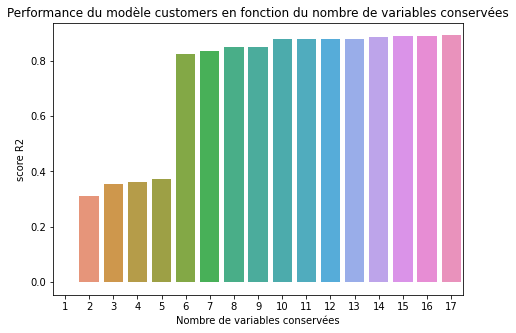

In [24]:
plot_bar(names, values)

On ne garde que le 10 variables les plus explicatives

In [0]:
X_train_customers = X_train[sorted_features[-10:]]

In [0]:
X_test_customers = X_test[X_train_customers.columns]

### Modèle sales

In [0]:
model_customers = Regressor()
model_customers.fit(X_train_customers, y_train_customers)


In [0]:
X_train["Customers_estimated"] = model_customers.predict(X_train_customers)


In [0]:
model_sales=Regressor()
model_sales.fit(X_train, y_train_sales)

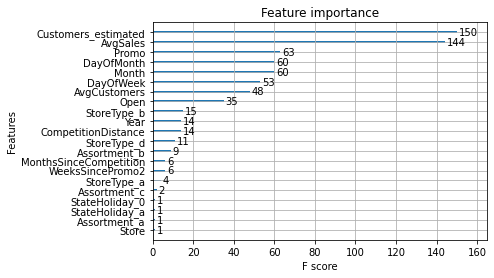

In [30]:
model_sales.plot_importance()
plt.show()

In [31]:
names, values, sorted_features = model_expl(model_sales)

n=20, R2: 0.94
n=19, R2: 0.94
n=18, R2: 0.94
n=17, R2: 0.94
n=16, R2: 0.94
n=15, R2: 0.94
n=14, R2: 0.94
n=13, R2: 0.94
n=12, R2: 0.94
n=11, R2: 0.94
n=10, R2: 0.94
n=9, R2: 0.94
n=8, R2: 0.94
n=7, R2: 0.94
n=6, R2: 0.91
n=5, R2: 0.80
n=4, R2: 0.55
n=3, R2: 0.55
n=2, R2: 0.57
n=1, R2: 0.46


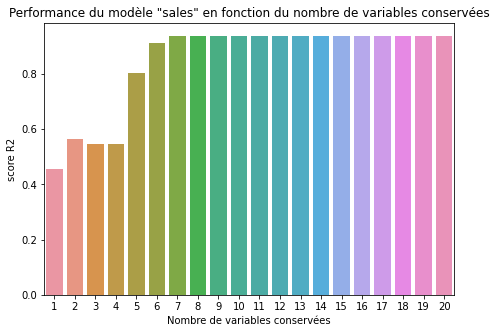

In [32]:
plot_bar(names, values, title='Performance du modèle "sales" en fonction du nombre de variables conservées')

In [0]:
X_train_sales = X_train[sorted_features[-8:]]

In [34]:
X_train_sales.columns.drop('Customers_estimated')

Index(['Open', 'AvgCustomers', 'DayOfWeek', 'Month', 'DayOfMonth', 'Promo',
       'AvgSales'],
      dtype='object')

In [0]:
X_test_sales = X_test[X_train_sales.columns.drop('Customers_estimated')]

# Model Validation

Pour la validation du modèle, nous allons effectuer une cross-validation

In [0]:
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error

In [37]:
xgbr_customers = xgb.XGBRegressor(silent=True)
xgbr_customers.fit(X_train_customers, y_train_customers)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

In [38]:
train_cv_scores_customers = cross_val_score(xgbr_customers, X_train_customers, y_train_customers, cv=5, n_jobs=2)
print("Train CV score for Customers: %.2f" % train_cv_scores_customers.mean())

Train CV score for Customers: 0.93


In [39]:
test_cv_scores_customers = cross_val_score(xgbr_customers, X_test_customers, y_test_customers, cv=5, n_jobs=2)
print("Test CV score for Customers: %.2f" % test_cv_scores_customers.mean())

Test CV score for Customers: 0.94


In [40]:
ypred_customers = xgbr_customers.predict(X_test_customers)
mse_customers = mean_squared_error(y_test_customers, ypred_customers)
print("RMSE for Customers: %.2f" % np.sqrt(mse_customers))

RMSE for Customers: 109.72


In [0]:
X_train_sales["Customers_estimated"] = xgbr_customers.predict(X_train_customers)
X_test_sales["Customers_estimated"] = ypred_customers

In [42]:
xgbr_sales = xgb.XGBRegressor(silent=True)
xgbr_sales.fit(X_train_sales, y_train_sales)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=1, verbosity=1)

In [43]:
train_cv_scores_sales = cross_val_score(xgbr_sales, X_train_sales, y_train_sales, cv=5)
print("Train CV score for Sales: %.2f" % train_cv_scores_sales.mean())

Train CV score for Sales: 0.90


In [44]:
test_cv_scores_sales = cross_val_score(xgbr_sales, X_test_sales, y_test_sales, cv=5)
print("Test CV score for Sales: %.2f" % test_cv_scores_sales.mean())

Test CV score for Sales: 0.90


In [45]:
ypred_sales = xgbr_sales.predict(X_test_sales)
mse_sales = mean_squared_error(y_test_sales, ypred_sales)
print("RMSE for Sales: %.2f" % np.sqrt(mse_sales))

RMSE for Sales: 1185.62


Text(0.5, 1.0, 'Train CV scores')

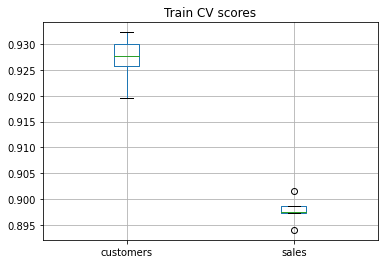

In [46]:
scores = pd.DataFrame({'customers': train_cv_scores_customers, 'sales': train_cv_scores_sales})
scores.boxplot()
plt.title('Train CV scores')

Text(0.5, 1.0, 'Test CV scores')

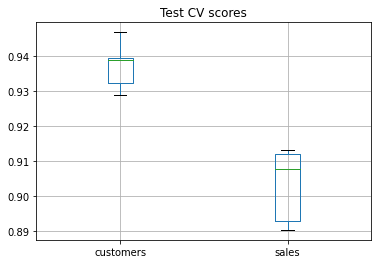

In [47]:
scores = pd.DataFrame({'customers': test_cv_scores_customers, 'sales': test_cv_scores_sales})
scores.boxplot()
plt.title('Test CV scores')

# Interprétation du modèle

In [49]:
!pip install shap

     |████████████████████████████████| 276kB 2.9MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394135 sha256=574be65da252aa45029c5446abd677b7d4a394933171541a8b4b97c17faff551
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [0]:
import shap

In [51]:
# load JS visualization code to notebook
shap.initjs()

In [0]:
explainer = shap.TreeExplainer(xgbr_customers)

In [0]:
shap_values = explainer.shap_values(X_test_customers, check_additivity=False)

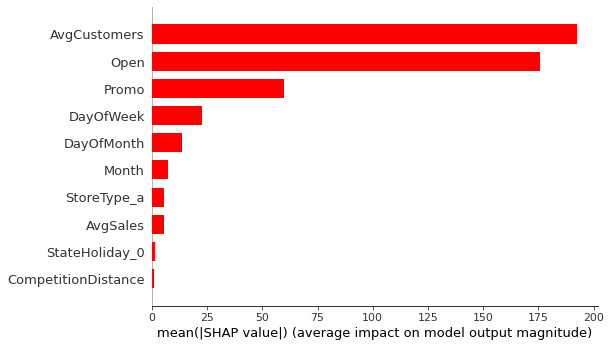

In [54]:
shap.summary_plot(shap_values, X_test_customers, plot_type="bar", color='red')

In [55]:
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_customers.iloc[0,:])

In [56]:
shap.force_plot(explainer.expected_value, shap_values[4,:], X_test_customers.iloc[4,:])

In [57]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X_test_customers.iloc[:1000,:])

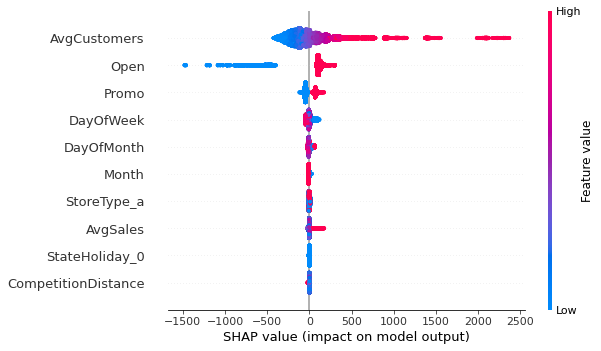

In [58]:
shap.summary_plot(shap_values, X_test_customers)

In [0]:
explainer2 = shap.TreeExplainer(xgbr_sales)

In [0]:
explainer2 = shap.TreeExplainer(xgbr_sales)

In [0]:
shap_values2 = explainer2.shap_values(X_test_sales, check_additivity=False)

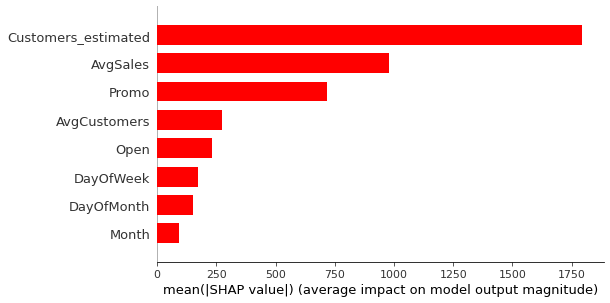

In [65]:
shap.summary_plot(shap_values2, X_test_sales, plot_type="bar", color='red')

In [66]:
shap.force_plot(explainer2.expected_value, shap_values2[0,:], X_test_sales.iloc[0,:])

In [67]:
shap.force_plot(explainer2.expected_value, shap_values2[0,:], X_test_sales.iloc[0,:])

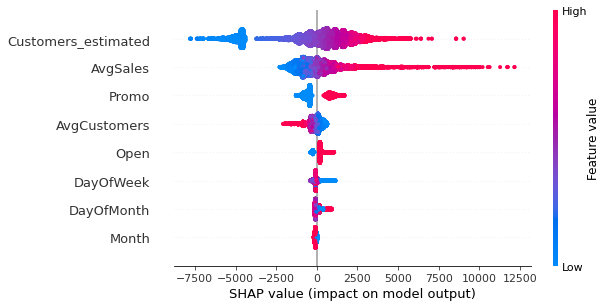

In [68]:
shap.summary_plot(shap_values2, X_test_sales)